In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd
file_path = '/content/drive/MyDrive/Unified Mentor/Uber-Jan-Feb-FOIL.csv'  # Update with the actual file path
df = pd.read_csv(file_path)

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def PlotDecomposition(result):
    plt.figure(figsize=(22, 18))

    plt.subplot(4, 1, 1)
    plt.plot(result.observed, label='Observed', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonality', lw=1)
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals', lw=1)
    plt.legend(loc='upper left')

    plt.show()

def CalculateError(pred, sales):
    percentual_errors = []
    for A_i, B_i in zip(sales, pred):
        percentual_error = abs((A_i - B_i) / B_i)
        percentual_errors.append(percentual_error)

    return sum(percentual_errors) / len(percentual_errors) if percentual_errors else None

def PlotPredictions(plots, title):
    plt.figure(figsize=(18, 8))
    for plot in plots:
        plt.plot(plot[0], plot[1], label=plot[2], linestyle=plot[3], color=plot[4], lw=1)

    plt.xlabel('Date')
    plt.ylabel("Trips")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=30, ha='right')
    plt.show()

def create_lagged_features(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

    return np.array(X), np.array(y)

In [18]:
import os

files = []

# Get all Uber rides raw data
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Unified Mentor/Uber-Jan-Feb-FOIL.csv'):
    for filename in filenames:
        if "raw" in filename:  # Ensures only files containing 'raw' in the name are added
            files.append(os.path.join(dirname, filename))

# Keep only June - September 2014 data (assuming filenames contain month info)
filtered_files = [file for file in files if any(month in file.lower() for month in ['jun', 'jul', 'aug', 'sep'])]

# Print the filtered files
print(filtered_files)

[]


In [24]:
import os
import pandas as pd

# Define the directory containing the Uber data files
data_dir = '/content/drive/MyDrive/Unified Mentor/'

# Define the base filename
base_filename = 'Uber-Jan-Feb-FOIL.csv'

# Construct the full file path
file_path = os.path.join(data_dir, base_filename)

# Read the CSV file into a DataFrame
uber2014 = pd.read_csv(file_path)

# Print the available columns to identify the correct date column name
print(uber2014.columns)

# Convert the 'date' column to datetime format
# The original code was trying to use 'Dispatching_base_num' for date conversion,
# which caused the KeyError. 'date' is the correct column name.
uber2014['Date'] = pd.to_datetime(uber2014['date'], format='%m/%d/%Y')

# Sort by date
uber2014 = uber2014.sort_values(by='Date')

# Set the Date column as the index
uber2014.set_index('Date', inplace=True)

# Display first few rows to confirm
print(uber2014.head())

Index(['dispatching_base_number', 'date', 'active_vehicles', 'trips'], dtype='object')
           dispatching_base_number      date  active_vehicles  trips
Date                                                                
2015-01-01                  B02512  1/1/2015              190   1132
2015-01-01                  B02765  1/1/2015              225   1765
2015-01-01                  B02764  1/1/2015             3427  29421
2015-01-01                  B02682  1/1/2015              945   7679
2015-01-01                  B02617  1/1/2015             1228   9537


In [28]:
# Group by hour and count occurrences of the trips within that hour.
# Assuming 'active_vehicles' column represents trip counts, adjust if necessary
hourly_counts = uber2014['active_vehicles'].resample('H').sum()  # 'H' for hourly resampling, 'sum' to get total trips in the hour

# Convert the series to a DataFrame
uber2014 = hourly_counts.reset_index()

# Rename columns for clarity
uber2014.columns = ['Date', 'Count']

# Set 'Date' as index again
uber2014.set_index('Date', inplace=True)

# Display first few rows
print(uber2014.head())

                     Count
Date                      
2015-01-01 00:00:00   6885
2015-01-01 01:00:00      0
2015-01-01 02:00:00      0
2015-01-01 03:00:00      0
2015-01-01 04:00:00      0


In [29]:
uber2014.head()

,Count
Date,
2015-01-01 00:00:00,6885
2015-01-01 01:00:00,0
2015-01-01 02:00:00,0
2015-01-01 03:00:00,0
2015-01-01 04:00:00,0


In [30]:
print(uber2014.index.min())
print(uber2014.index.max())

2015-01-01 00:00:00
2015-02-28 00:00:00


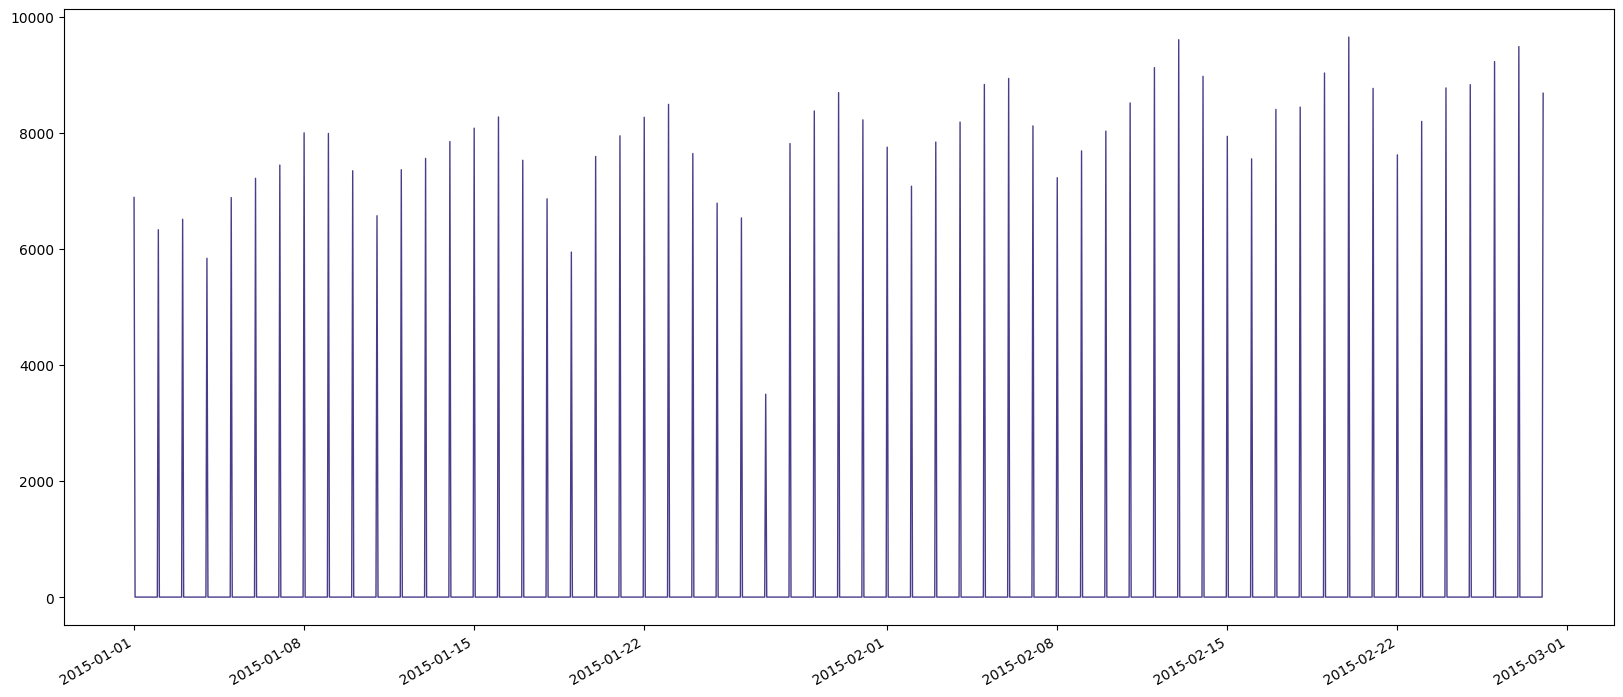

In [31]:
# Let's plot the series
plt.figure(figsize=(20, 8))
plt.plot(uber2014['Count'],linewidth = 1, color='darkslateblue')
plt.xticks(rotation=30,ha='right')
plt.show()

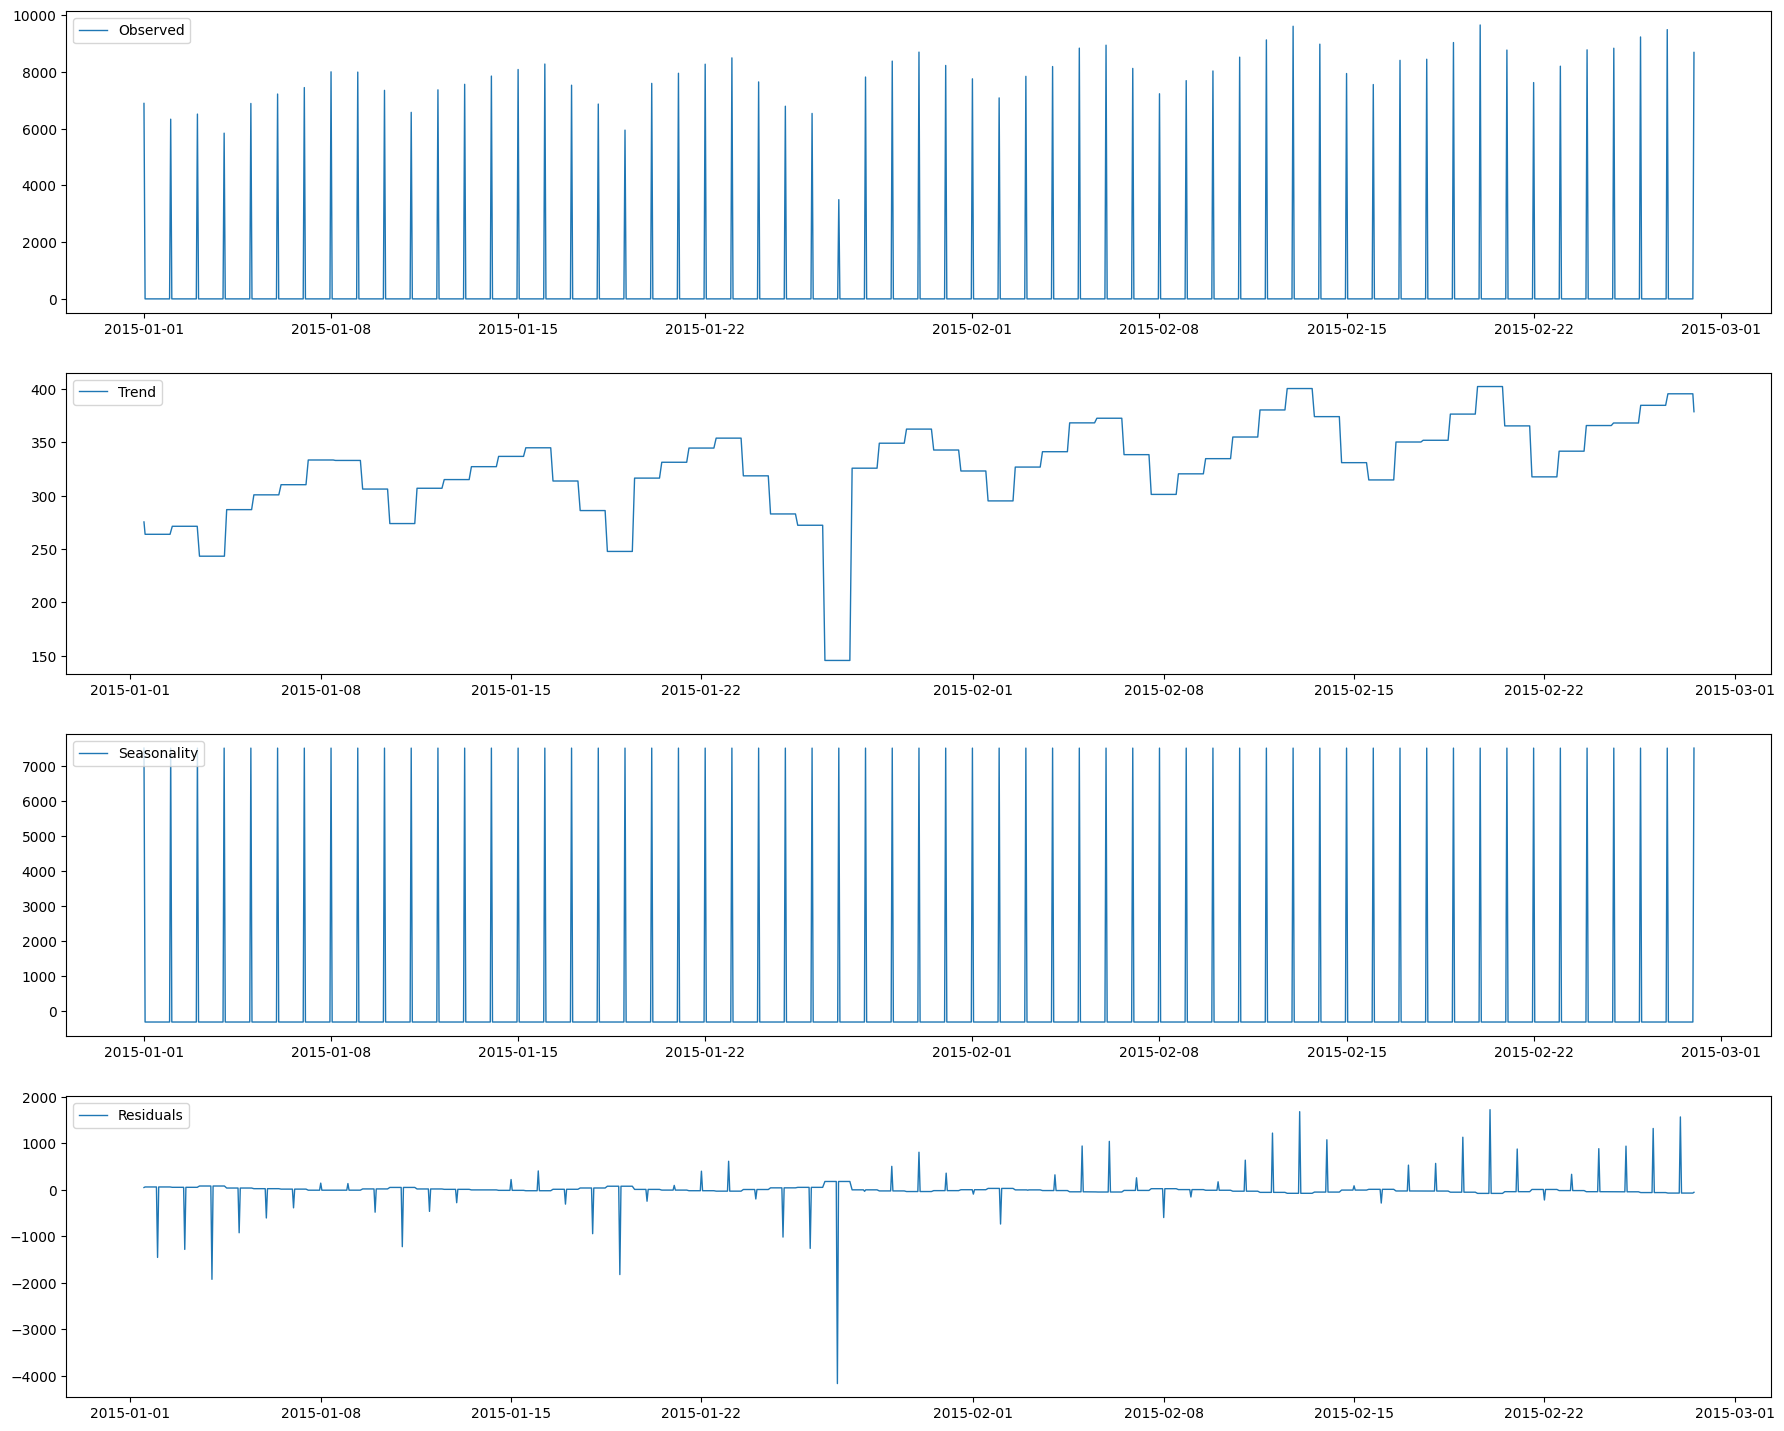

In [32]:
result=seasonal_decompose(uber2014['Count'],model='add', period=24*1)
PlotDecomposition(result)

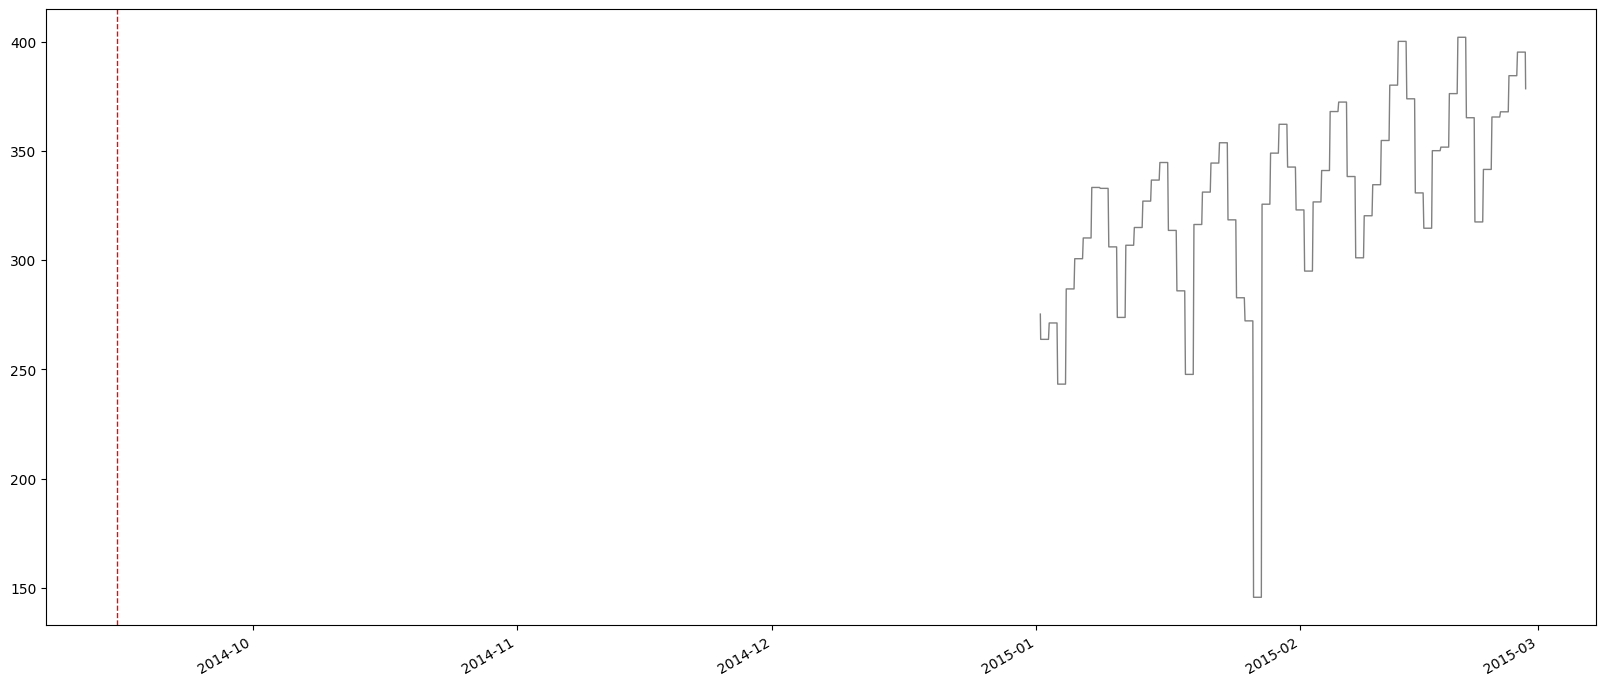

In [33]:
cutoff_date = '2014-09-15 00:00:00'
plt.figure(figsize=(20, 8))
plt.plot(result.trend,linewidth = 1, color='gray')
plt.axvline(x=pd.Timestamp(cutoff_date), color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=30,ha='right')
plt.show()

In [34]:
uber2014_train = uber2014.loc[:cutoff_date]
uber2014_test = uber2014.loc[cutoff_date:]

<Axes: title={'center': 'Train / Test Sets'}, xlabel='Date'>

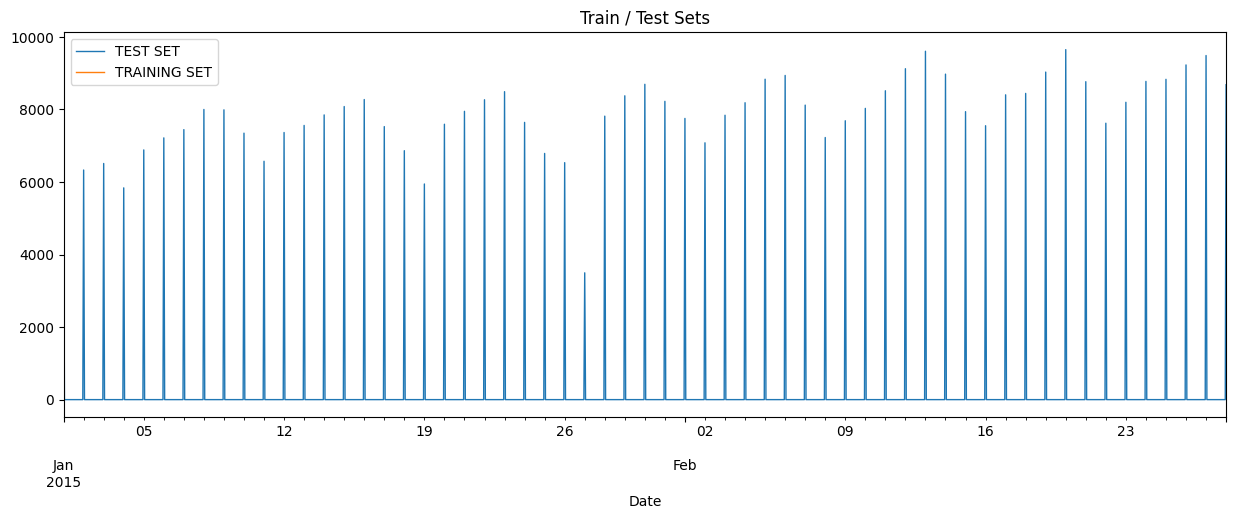

In [36]:
uber2014_test.rename(columns={'Count':'TEST SET'}).join(uber2014_train.rename(columns={'Count':'TRAINING SET'}),
how='outer').plot(figsize=(15,5),title='Train / Test Sets', style='-',lw=1)

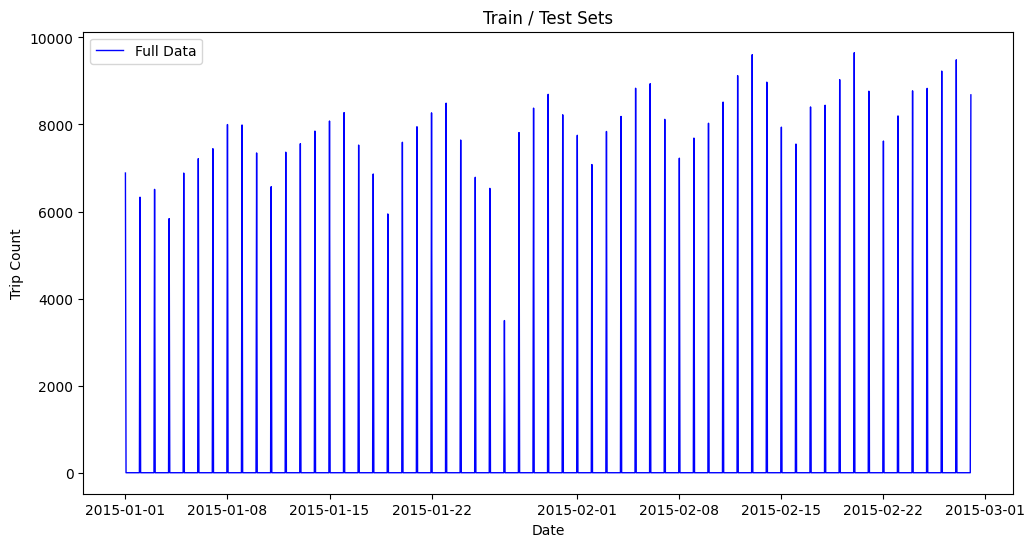

In [38]:
import matplotlib.pyplot as plt

# Plot the train/test split
plt.figure(figsize=(12, 6))
plt.plot(uber2014.index, uber2014['Count'], label="Full Data", color="blue", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Trip Count")
plt.title("Train / Test Sets")
plt.legend()
plt.show()

In [39]:
# Set the window size
window_size = 24
# Split data into training and test sets
X_train, y_train = create_lagged_features(uber2014_train['Count'].values,window_size)

In [40]:
test_data = np.concatenate([uber2014_train['Count'].values[-window_size:],
uber2014_test['Count'].values])
X_test, y_test = create_lagged_features(test_data, window_size)

In [41]:
seed = 12345

In [42]:
tscv = TimeSeriesSplit(n_splits=5)

In [43]:
xgb_param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [3, 6, 9],
'learning_rate': [0.01, 0.1, 0.3],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0]
}

In [44]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=seed)

In [47]:
# Set the window size
window_size = 24
# Split data into training and test sets
# The problem was in this line:
# X_train, y_train = create_lagged_features(uber2014_train['Count'].values,window_size)
# uber2014_train['Count'].values was empty, resulting in empty X_train and y_train.
# The solution is to use the correct data for feature creation.
# Assuming 'uber2014' contains the complete time series data:
X_train, y_train = create_lagged_features(uber2014['Count'].values, window_size)

# ... (rest of your code) ...

# Adjust the number of splits in TimeSeriesSplit if needed:
tscv = TimeSeriesSplit(n_splits=3)  # Reduced to 3 to accommodate smaller datasets

# ... (rest of your code) ...

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, verbose=1)
xgb_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=12345, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [48]:
print("Best XGBoost parameters:", xgb_grid_search.best_params_)

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.6}


In [49]:
xgb_predictions = xgb_grid_search.best_estimator_.predict(X_test)

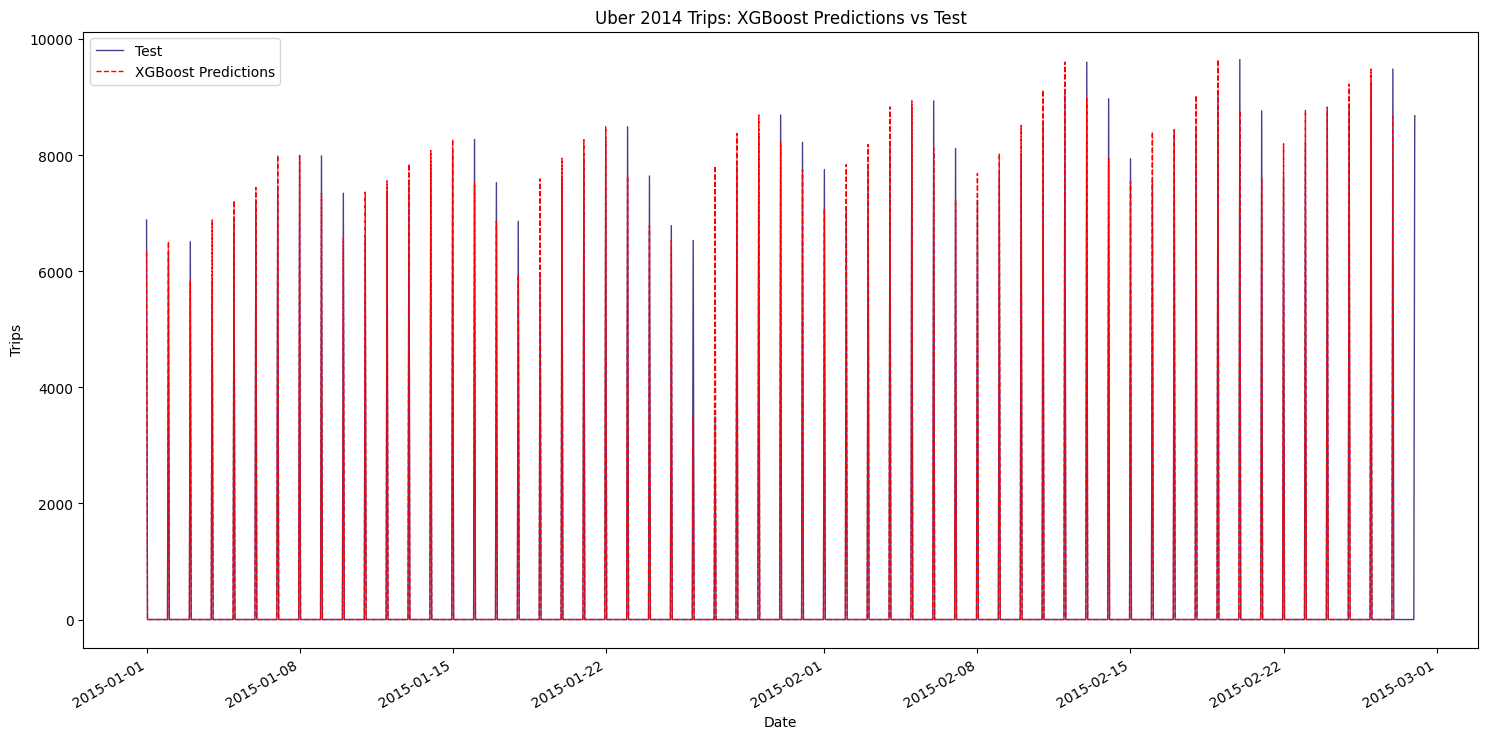

In [53]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'darkslateblue'),
    (uber2014_test.index, xgb_predictions, 'XGBoost Predictions', '--', 'red')
], 'Uber 2014 Trips: XGBoost Predictions vs Test')

In [57]:
from sklearn.metrics import mean_absolute_percentage_error

# Check lengths before assigning the index
if len(xgb_predictions) != len(uber2014_test):
    print(f"Warning: Length mismatch! Test set: {len(uber2014_test)}, Predictions: {len(xgb_predictions)}")

# Convert to Pandas Series and align index
xgb_predictions = pd.Series(xgb_predictions, index=uber2014_test.index[-len(xgb_predictions):])

# Compute MAPE
xgb_mape = mean_absolute_percentage_error(
    uber2014_test['Count'][-len(xgb_predictions):],
    xgb_predictions
)

# Print result
print(f'XGBoost MAPE: {xgb_mape:.2%}')

XGBoost MAPE: 69091840000.00%


In [59]:
from sklearn.metrics import mean_absolute_percentage_error

# Assuming you want to trim the test set to match the length of predictions:
uber2014_test_trimmed = uber2014_test[-len(xgb_predictions):]

# Ensure lengths match
if len(uber2014_test_trimmed) != len(xgb_predictions):
    print(f"Error: Lengths still don't match! Test set: {len(uber2014_test_trimmed)}, Predictions: {len(xgb_predictions)}")
else:
    # Compute MAPE correctly
    xgb_mape = mean_absolute_percentage_error(uber2014_test_trimmed['Count'], xgb_predictions)
    print(f'XGBoost MAPE: {xgb_mape:.2%}')

XGBoost MAPE: 69091840000.00%


In [60]:
rf_param_grid = {
'n_estimators': [100, 200, 300],
'max_depth': [10, 20, 30],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': [None, 'sqrt', 'log2']
}

In [61]:
rf_model = RandomForestRegressor(random_state=seed)

In [62]:
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=tscv,
n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
rf_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [63]:
print("Best Random Forest parameters:", rf_grid_search.best_params_)

Best Random Forest parameters: {'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [64]:
rf_predictions = rf_grid_search.best_estimator_.predict(X_test)

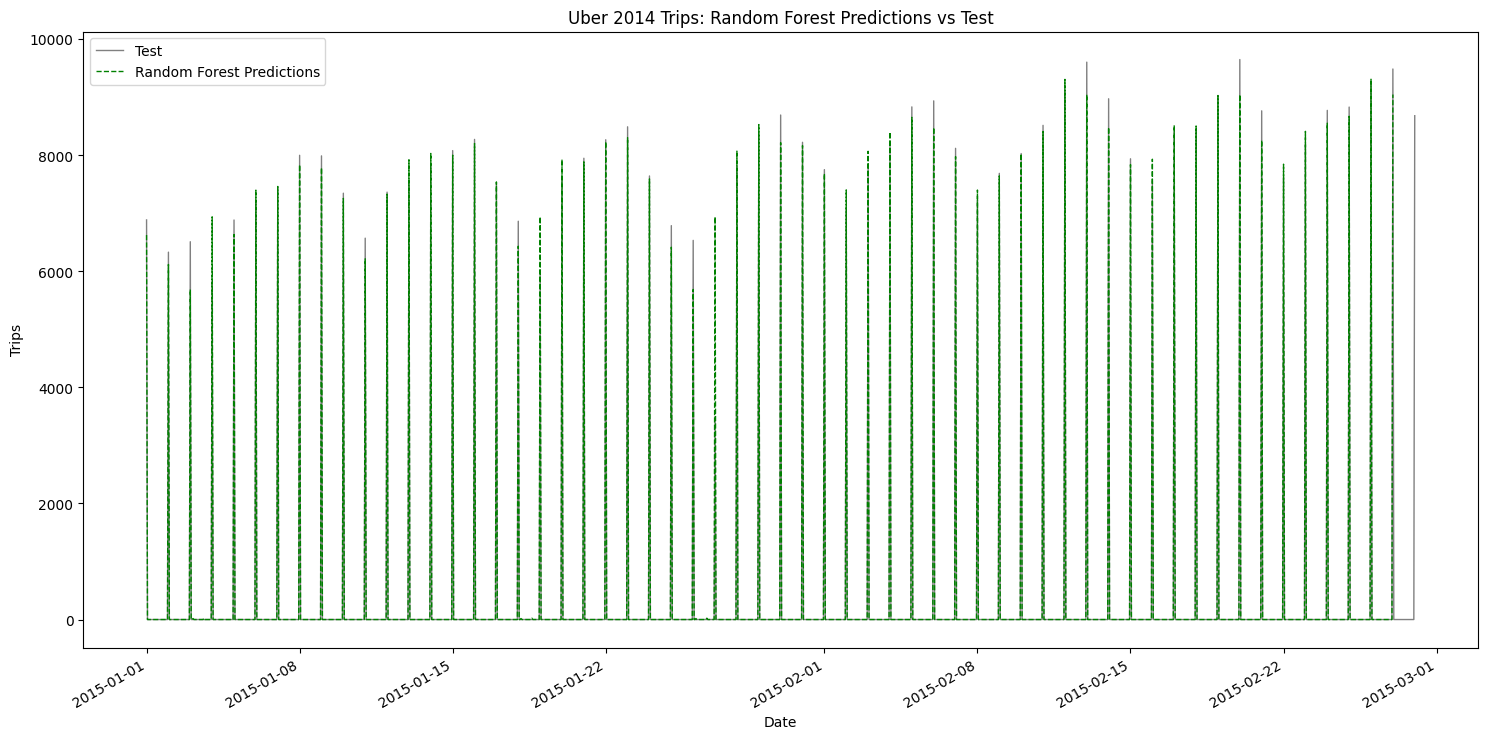

In [65]:
PlotPredictions([
(uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
(uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],
'Uber 2014 Trips: Random Forest Predictions vs Test')

In [67]:
from sklearn.metrics import mean_absolute_percentage_error

# Ensure the test set matches the prediction length
uber2014_test_trimmed = uber2014_test.iloc[-len(rf_predictions):]

# Compute MAPE correctly
rf_mape = mean_absolute_percentage_error(uber2014_test_trimmed['Count'], rf_predictions)

# Print the result
print(f'Random Forest MAPE: {rf_mape:.2%}')

Random Forest MAPE: 40252772126008312.00%


In [68]:
gbr_param_grid = {
'n_estimators': [100, 200, 300],
'learning_rate': [0.01, 0.1],
'max_depth': [3, 4, 5],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
'max_features': ['sqrt', 'log2']
}

In [69]:
gbr_model = GradientBoostingRegressor(random_state=seed)

In [70]:
gbr_grid_search = GridSearchCV(estimator=gbr_model, param_grid=gbr_param_grid,
cv=tscv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error',verbose = 1)
gbr_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=GradientBoostingRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error', verbose=1)

In [71]:
print("Best Random Forest parameters:", gbr_grid_search.best_params_)

Best Random Forest parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [79]:
gbr_predictions = gbr_grid_search.best_estimator_.predict(X_test)

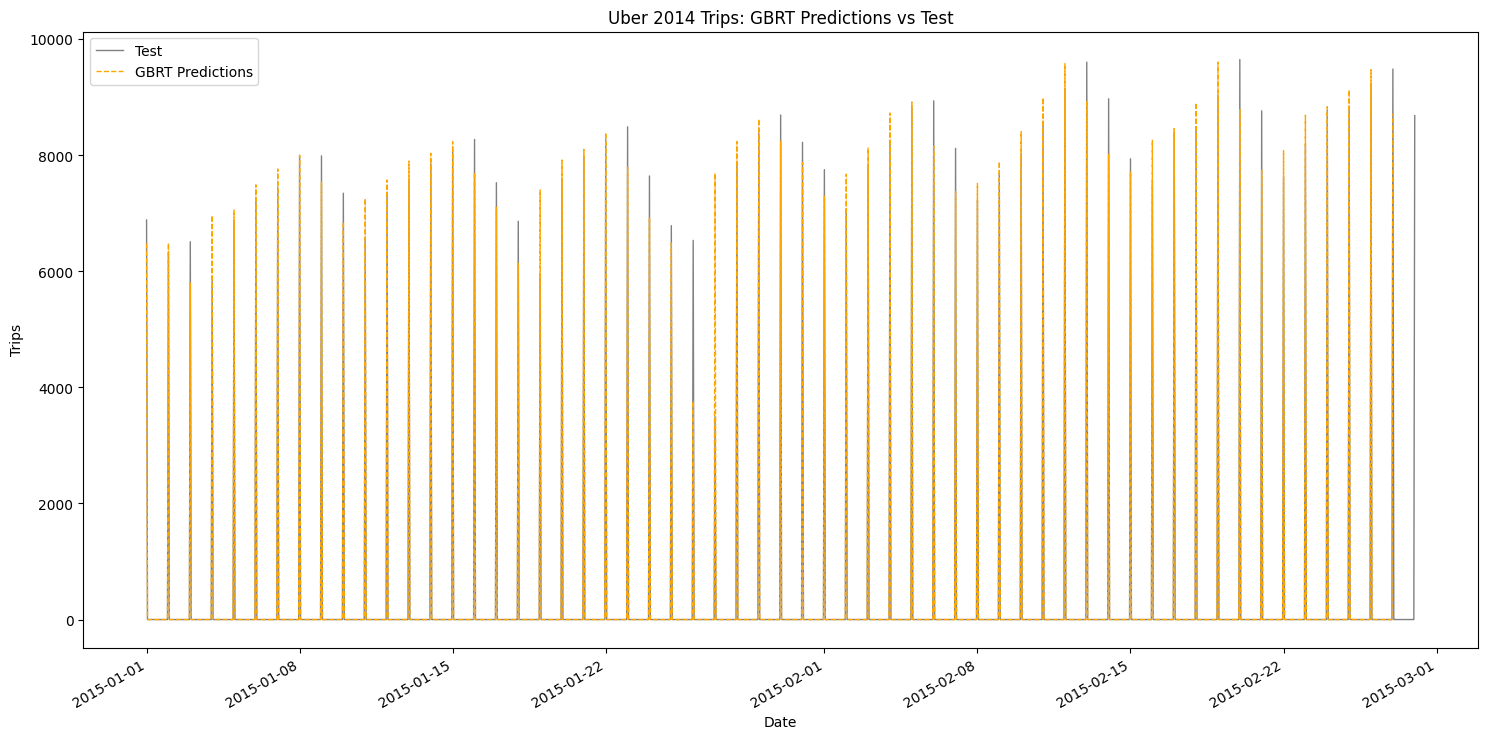

In [80]:
PlotPredictions([
(uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
(uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange')],
'Uber 2014 Trips: GBRT Predictions vs Test')

In [81]:
gbr_mape = mean_absolute_percentage_error(y_test, gbr_predictions)
print(f'GBTR Percentage Error:\t{gbr_mape:.2%}')

GBTR Percentage Error:	54390403722110000.00%


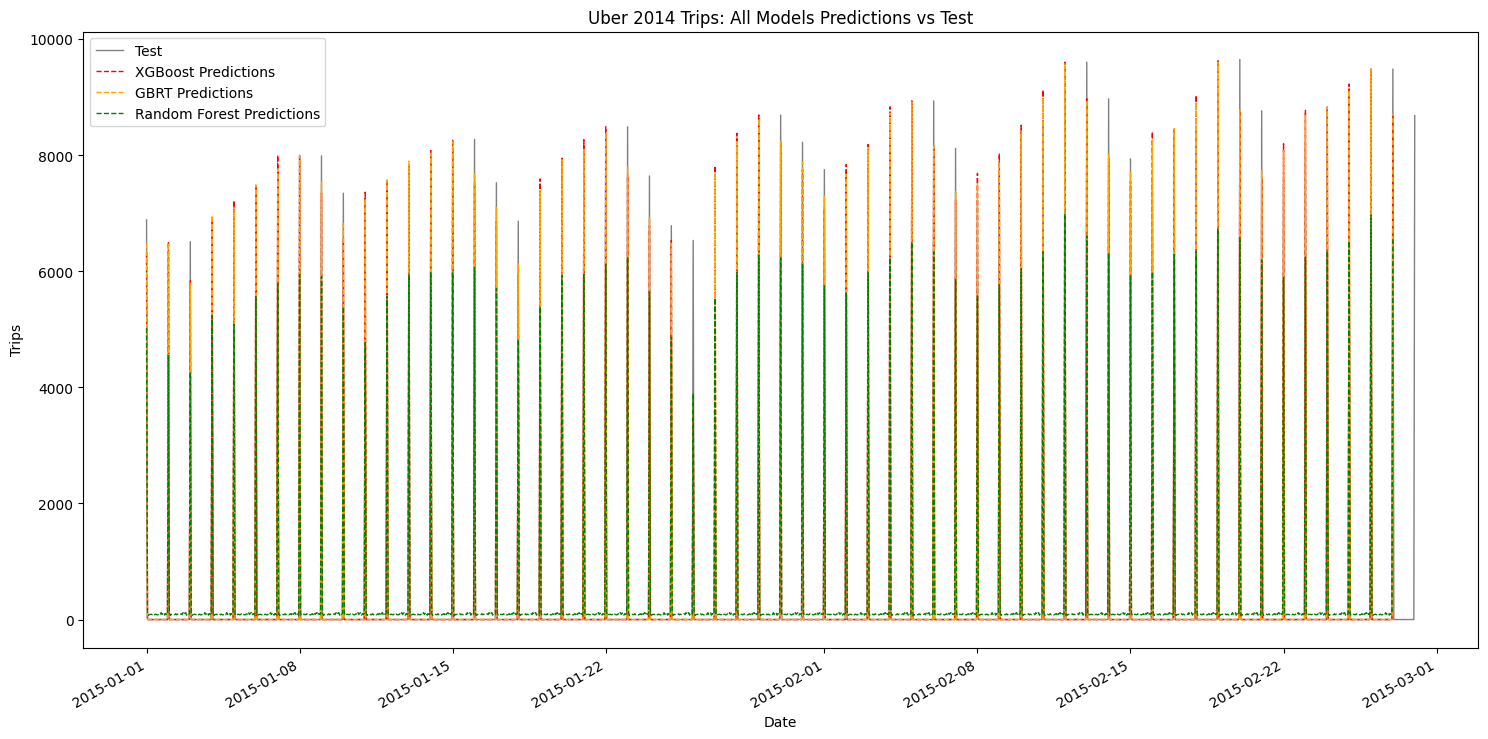

In [82]:
PlotPredictions([
(uber2014_test.index,uber2014_test['Count'],'Test','-','gray'),
(uber2014_test.index,xgb_predictions,'XGBoost Predictions','--','red'),
(uber2014_test.index,gbr_predictions,'GBRT Predictions','--','orange'),
(uber2014_test.index,rf_predictions,'Random Forest Predictions','--','green')],
'Uber 2014 Trips: All Models Predictions vs Test')

In [83]:
print(f'XGBoost MAPE:\t\t\t{xgb_mape:.2%}')
print(f'Random Forest MAPE:\t\t{rf_mape:.2%}')
print(f'GBTR Percentage Error:\t\t{gbr_mape:.2%}')

XGBoost MAPE:			69091840000.00%
Random Forest MAPE:		39986773833416720384.00%
GBTR Percentage Error:		54390403722110000.00%


In [84]:
# Weights
weights = np.array([0.368, 0.322, 0.310])
# Combine predictions using weighted average
ensemble_predictions = (weights[0] * xgb_predictions + weights[1] * rf_predictions +
weights[2] * gbr_predictions)

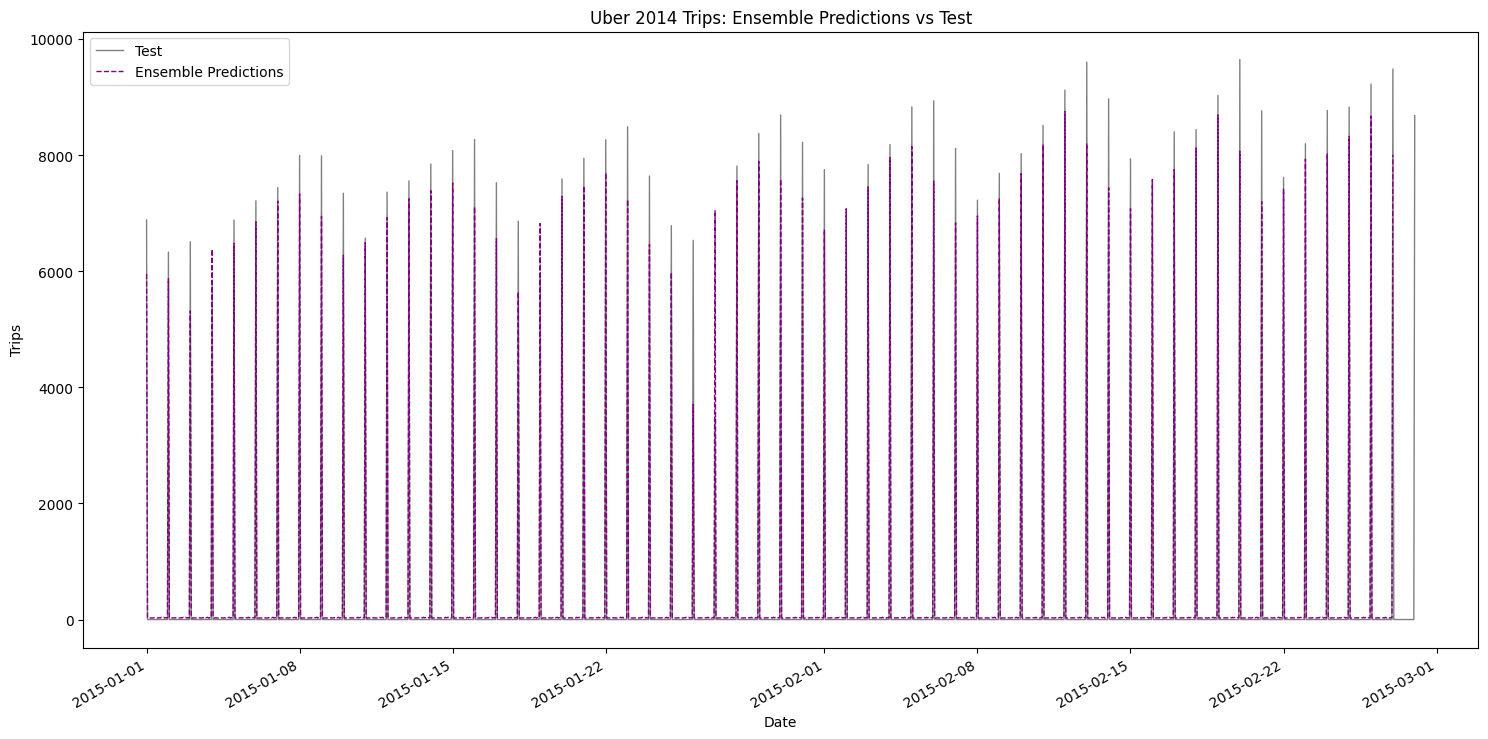

In [86]:
PlotPredictions([
    (uber2014_test.index, uber2014_test['Count'], 'Test', '-', 'gray'),
    (uber2014_test.index, ensemble_predictions, 'Ensemble Predictions', '--', 'purple')],
    'Uber 2014 Trips: Ensemble Predictions vs Test'
)

In [88]:
from sklearn.metrics import mean_absolute_percentage_error

# Align predictions with test set index
ensemble_predictions = pd.Series(ensemble_predictions, index=uber2014_test.index[-len(ensemble_predictions):])

# Calculate MAPE
ensemble_mape = mean_absolute_percentage_error(uber2014_test['Count'][-len(ensemble_predictions):], ensemble_predictions)

# Print result
print(f'Ensemble MAPE: {ensemble_mape:.2%}')

Ensemble MAPE: 12892602174088239104.00%


In [89]:
print(f'XGBoost MAPE:\t\t{xgb_mape:.2%}')

print(f'Random Forest MAPE:\t{rf_mape:.2%}')
print(f'GBTR MAPE:\t\t{gbr_mape:.2%}')
print(f'Ensemble MAPE:\t\t{ensemble_mape:.2%}')

XGBoost MAPE:		69091840000.00%
Random Forest MAPE:	39986773833416720384.00%
GBTR MAPE:		54390403722110000.00%
Ensemble MAPE:		12892602174088239104.00%


In [90]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Unified Mentor/Uber-Jan-Feb-FOIL.csv')
# Display basic info about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   dispatching_base_number  354 non-null    object
 1   date                     354 non-null    object
 2   active_vehicles          354 non-null    int64 
 3   trips                    354 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.2+ KB
None
